All instructions are provided for R. I am going to reproduce them in Python as best as I can.

# Preface

From the textbook, p. 334:
> This problem involves the `OJ` data set which is part of the `ISLR`
package.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree


%matplotlib inline

In [2]:
oj = pd.read_csv('https://raw.githubusercontent.com/dsnair/ISLR/master/data/csv/OJ.csv')
oj.head(3)

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
0,CH,237,1,1.75,1.99,0.00,0.0,0,0,0.50,1.99,1.75,0.24,No,0.000000,0.000000,0.24,1
1,CH,239,1,1.75,1.99,0.00,0.3,0,1,0.60,1.69,1.75,-0.06,No,0.150754,0.000000,0.24,1
2,CH,245,1,1.86,2.09,0.17,0.0,0,0,0.68,2.09,1.69,0.40,No,0.000000,0.091398,0.23,1


Columns:
* `Purchase` &mdash; a factor with levels CH and MM indicating whether the customer purchased Citrus Hill or Minute Maid Orange Juice;
* `WeekofPurchase` &mdash; week of purchase;
* `StoreID` &mdash; store ID;
* `PriceCH` &mdash; price charged for CH;
* `PriceMM` &mdash; price charged for MM;
* `DiscCH` &mdash; discount offered for CH;
* `DiscMM` &mdash; discount offered for MM;
* `SpecialCH` &mdash; indicator of special on CH;
* `SpecialMM` &mdash; indicator of special on MM;
* `LoyalCH` &mdash; customer brand loyalty for CH;
* `SalePriceMM` &mdash; sale price for MM;
* `SalePriceCH` &mdash; sale price for CH;
* `PriceDiff` &mdash; sale price of MM less sale price of CH;
* `Store7` &mdash; a factor with levels No and Yes indicating whether the sale is at Store 7;
* `PctDiscMM` &mdash; percentage discount for MM;
* `PctDiscCH` &mdash; percentage discount for CH;
* `ListPriceDiff` &mdash; list price of MM less list price of CH;
* `STORE` &mdash; which of 5 possible stores the sale occured at.

# (a)

From the textbook, p. 334:
> Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations.

(It is told later, that `Purchase` is the response in this exercise.)

In [3]:
np.random.seed(1)
x = pd.get_dummies(oj.drop('Purchase', axis='columns'), drop_first=True)
y = oj.Purchase
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=800)

# (b)

From the textbook, p. 334:
> Fit a tree to the training data, with `Purchase` as the response and the other variables as predictors. Use the `summary()` function to produce summary statistics about the tree, and describe the results obtained. What is the training error rate? How many terminal nodes does the tree have?

In [4]:
model_b = DecisionTreeClassifier()
model_b.fit(x_train, y_train)
importances = model_b.feature_importances_
pd.DataFrame({'Importance' : importances}
             , index=x.columns
            ).sort_values('Importance', ascending=False)

,Importance
LoyalCH,0.623310
WeekofPurchase,0.117668
PriceDiff,0.075003
SalePriceMM,0.036058
STORE,0.033448
StoreID,0.027691
SpecialCH,0.027248
SalePriceCH,0.014738
PriceCH,0.012351
ListPriceDiff,0.009141


`statsmodels` package does not have decision trees; `sklearn` does not have `summary()` for its models. I am going to print the most important (and the easiest to get) metrics.

In [13]:
print(
  f'Classification tree\n'
  f'Number of terminal nodes: {model_b.get_n_leaves()}\n'
  f'Variables actually used in tree construction:\n'
  f'{x.columns.to_numpy()[importances > 0.05]}\n'
  f'Misclassification error rate: {1 - model_b.score(x_train, y_train)}'
)

Classification tree
Number of terminal nodes: 164
Variables actually used in tree construction:
['WeekofPurchase' 'LoyalCH' 'PriceDiff']
Misclassification error rate: 0.010000000000000009


# (c)

From the textbook, p. 334:
> Type in the name of the tree object in order to get a detailed text output. Pick one of the terminal nodes, and interpret the information displayed.

In [6]:
print(export_text(model_b, feature_names=x.columns.to_list()))

|--- LoyalCH <= 0.45
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.05
|   |   |   |--- StoreID <= 2.50
|   |   |   |   |--- LoyalCH <= 0.00
|   |   |   |   |   |--- WeekofPurchase <= 269.50
|   |   |   |   |   |   |--- class: CH
|   |   |   |   |   |--- WeekofPurchase >  269.50
|   |   |   |   |   |   |--- class: MM
|   |   |   |   |--- LoyalCH >  0.00
|   |   |   |   |   |--- class: MM
|   |   |   |--- StoreID >  2.50
|   |   |   |   |--- class: MM
|   |   |--- LoyalCH >  0.05
|   |   |   |--- WeekofPurchase <= 249.50
|   |   |   |   |--- STORE <= 1.50
|   |   |   |   |   |--- WeekofPurchase <= 235.50
|   |   |   |   |   |   |--- WeekofPurchase <= 232.00
|   |   |   |   |   |   |   |--- class: MM
|   |   |   |   |   |   |--- WeekofPurchase >  232.00
|   |   |   |   |   |   |   |--- SpecialCH <= 0.50
|   |   |   |   |   |   |   |   |--- class: CH
|   |   |   |   |   |   |   |--- SpecialCH >  0.50
|   |   |   |   |   |   |   |   |--- LoyalCH <= 0.22
|   |   |   |   |   |   |   |   

The tree is very complex. I'm picking this path:
`LoyalCH <= 0.45` - `LoyalCH <= 0.28` - `LoyalCH <= 0.05` - `StoreID <= 2.50` - `LoyalCH <= 0.00` - `WeekofPurchase <= 269.50` - `class: CH`.

The interpretation: if a customer that is not loyal to Citrus Hill at all buys orange juice at a store with ID 1 or 2 before week 270 (of what?), he is more likely to choose Citrus Hill. Seems quite arbitrary.

# (d)

From the textbook, p. 334:
> Create a plot of the tree, and interpret the results.

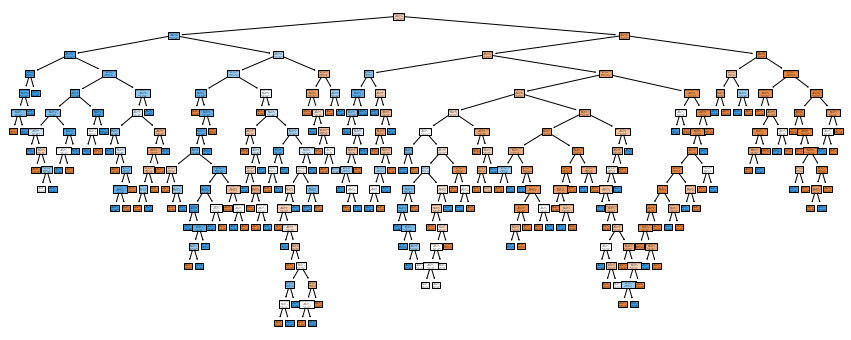

In [7]:
plt.figure(figsize=(15, 6))
plot_tree(model_b
          , feature_names=x.columns.to_list()
          , class_names=['CH', 'MM']
          , filled=True
          )
plt.show()

The full tree is uninterprepable.

# (e)

From the textbook, p. 334:
> Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?

In [20]:
y_pred = model_b.predict(x_test)
print('Confusion matrix:')
print(confusion_matrix(y_pred, y_test))
print(f'\nTest error rate: {1 - accuracy_score(y_pred, y_test):.2f}')

Confusion matrix:
[[134  41]
 [ 23  72]]

Test error rate: 0.24


# (f)

From the textbook, p. 334:
> Apply the `cv.tree()` function to the training set in order to determine the optimal tree size.

In [21]:
parameters = {'max_depth' : np.arange(1, 30)}
model_f = GridSearchCV(DecisionTreeClassifier(), parameters)
model_f.fit(x_train, y_train)
model_f.best_params_

{'max_depth': 3}

# (g)

From the textbook, p. 334:
> Produce a plot with tree size on the x-axis and cross-validated classification error rate on the y-axis.

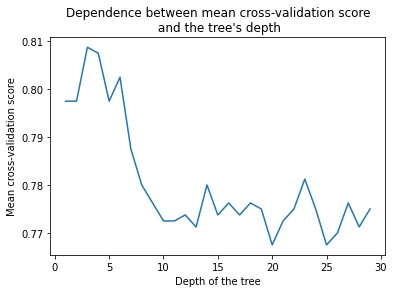

In [22]:
sns.lineplot(x=parameters['max_depth']
             , y=model_f.cv_results_['mean_test_score']
)
plt.title('Dependence between mean cross-validation score\n and the tree\'s depth')
plt.xlabel('Depth of the tree')
plt.ylabel('Mean cross-validation score')
plt.show()

# (h)

From the textbook, p. 334:
> Which tree size corresponds to the lowest cross-validated classification error rate?

The tree of size 3 corresponds to the lowest cross-validated classification error rate.

# (i)

From the textbook, p. 334:
> Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead to selection of a pruned tree, then create a pruned tree with five terminal nodes.

`model_f` is exactly such a tree.

# (j)

From the textbook, p. 334:
> Compare the training error rates between the pruned and unpruned trees. Which is higher?

In [23]:
print(f'Unpruned train error: '
      f'{1 - model_b.score(x_train, y_train):.3f}\n'
      f'Pruned train error: '
      f'{1 - model_f.score(x_train, y_train):.3f}'
)

Unpruned train error: 0.010
Pruned train error: 0.152


Training rate of the pruned tree is higher.

# (k)

From the textbook, p. 334:
> Compare the test error rates between the pruned and unpruned trees. Which is higher?

In [25]:
print(f'Unpruned test error: '
      f'{1 - model_b.score(x_test, y_test):.3f}\n'
      f'Pruned test error: '
      f'{1 - model_f.score(x_test, y_test):.3f}'
)

Unpruned test error: 0.237
Pruned test error: 0.181


Unpruned test error is higher. This means that the full tree is overfitting.